Importing the libraries and the csv

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import WhitespaceTokenizer

import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import torch
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import DistilBertTokenizer, DistilBertModel

from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
from matplotlib.colors import ListedColormap

c = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#6fdc8c', '#d12771', '#d2a106', '#ba4e00', '#d4bbff']
col = ListedColormap(sns.color_palette(c).as_hex())

In [ ]:
df = pd.read_csv('./data/lyrics_def_noDupl.csv')
df.drop('language', axis=1, inplace=True)
df.drop(df[df.year < 1968].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
sns.set_theme()
sns.set_context("talk")

## Clean lyrics

In [ ]:
STOPWORDS = nltk.corpus.stopwords.words("english") 
lemmatizer = nltk.stem.WordNetLemmatizer()

STOPWORDS.extend(["i'm","eh", "oh", "aren’t","are not","can’t","cannot","couldn’t","could not","didn’t","did not","doesn’t","does not","don’t","do not","hadn’t","had not","hasn’t","has not","haven’t","have not","he’d","he had","he would","he’ll","he will","he shall","he’s","he is","he has","I’d","I had","I would","I’ll","I will","I shall","I’m","I am","I’ve","I have","isn’t","is not","let’s","let us","mightn’t","might not","mustn’t","must not","shan’t","shall not","she’d","she had","she would","she’ll","she will","she shall","she’s","she is","she has","shouldn’t","should not","that’s","that is","that has","there’s","there is","there has","they’d","they had","they would","they’ll","they will","they shall","they’re","they are","they’ve","they have","we’d","we had","we would","we’re","we are","we’ve","we have","weren’t","were not","what’ll","what will","what shall","what’re","what are","what’s","what is","what has","what’ve","what have","where’s","where is","where has","who’d","who had","who would","who’ll","who will","who shall","who’re","who are","who’s","who is","who has","who’ve","who have","won’t","will not","wouldn’t","would not","you’d","you had","you would","you’ll","you will","you shall","you’re","you are","you’ve","you have"])

In [ ]:
def clean_abbreviation(token):
    if token == 'u':
        return 'you'
    if token == '\'d':
        return ''
    if token == 'id':
        return 'i'
    if token == 'im':
        return 'i am'
    if token == 'i\'ma':
        return 'i am a'
    if token == 'ima':
        return 'i am a'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == 'yall':
        return 'you all'
    if token == 'ive':
        return 'i have'
    if token == 'dont':
        return 'do not'
    if token == '4got' or token == '4gotten':
        return 'forget'
    return token

In [ ]:
def clearLyrics(df):
    lyrics_cleaned = []

    for idx, row in tqdm(df.iterrows(), desc='Cleaning Lyrics', total=len(df)):
        #if idx % 50000 == 0:
        #    print(f'Song number {idx} cleaned')
            
        new_lyric = ""
        new_lyric = re.sub("[^\x00-\x7F]+", ' ', row.lyrics) ## elimina caratteri strani a causa della codifica in ASCII
        new_lyric = re.sub("[\(\[].*?[\)\]]", ' ', new_lyric) ## elimina le parole contenute dentro le parentesi
        new_lyric = re.sub("x[0-9]+", " ", new_lyric) ## elimina x2, x3, ecc.
        new_lyric = re.sub("[0-9]x+", " ", new_lyric) ## elimina 2x, 3x, ecc.
        new_lyric = re.sub("[^\w\s^']", '', new_lyric) ##elimina punteggiatura tranne che apostrofi
        new_lyric = re.sub("\\n", " ", new_lyric) ## elimina gli /n
        new_lyric = re.sub(' {2,}', " ", new_lyric) ## elimina gli spazi superflui
        new_lyric = new_lyric.lower()
        #new_lyric = ' '.join((clean_abbreviation(tok.lower()) for tok in new_lyric))
        #new_lyric = ' '.join([lemmatizer.lemmatize(i) for i in new_lyric if i not in STOPWORDS])

        lyrics_cleaned.append(new_lyric)

    df['lyrics_cleaned'] = lyrics_cleaned

    return df

In [ ]:
df = clearLyrics(df)

Cleaning Lyrics:   0%|          | 0/189388 [00:00<?, ?it/s]

## TfidVectorizer

In [ ]:
X = df['lyrics_cleaned']
y = df['genre']

In [ ]:
genre_list = list(y.unique())
#genre_list.sort()
genre_list

['Pop',
 'Hip-Hop',
 'Rock',
 'Metal',
 'Country',
 'Jazz',
 'Electronic',
 'Folk',
 'R&B',
 'Indie']

In [ ]:
### Single words
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_features=3000)
vectorizer.fit(X)
X11 = vectorizer.transform(X)

### Clustering

In [ ]:
pca = TruncatedSVD(n_components=2, random_state=42)
X_pca = pca.fit_transform(X11)

Compute the SSE for each k cluster

In [ ]:
sse_list = []

for k in range(2, 10):
    print(f'-- Test with k = {k}')
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    print('Fitting...')
    kmeans.fit(X_pca)
    print('Evaluating SSE...')
    sse_list.append( kmeans.inertia_ )
    #silhouette_list.append(silhouette_score(X_pca, kmeans.labels_))

-- Test with k = 2
Fitting...
Evaluating SSE...
-- Test with k = 3
Fitting...
Evaluating SSE...
-- Test with k = 4
Fitting...
Evaluating SSE...
-- Test with k = 5
Fitting...
Evaluating SSE...
-- Test with k = 6
Fitting...
Evaluating SSE...
-- Test with k = 7
Fitting...
Evaluating SSE...
-- Test with k = 8
Fitting...
Evaluating SSE...
-- Test with k = 9
Fitting...
Evaluating SSE...


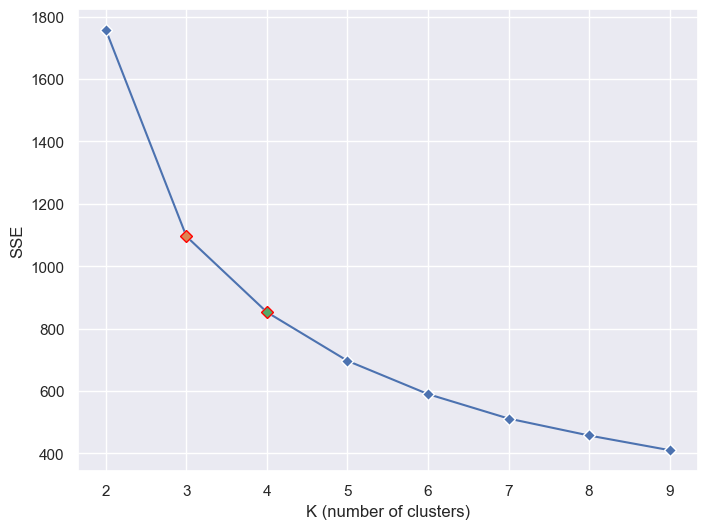

In [ ]:
# plot of SSE, Elbow method

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
plt.plot(range(2, len(sse_list)+2), sse_list, marker='D', mec='white')
plt.plot(3, sse_list[1], marker='D', mec='red')
plt.plot(4, sse_list[2], marker='D', mec='red')
plt.xlabel('K (number of clusters)')
plt.ylabel('SSE')
plt.show()

In [ ]:
silhouette_list = []

for k in range(3, 5):
    print(f'-- Test with k = {k}')
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    print('Fitting...')
    kmeans.fit(X_pca)
    print('Evaluating Silhouette Score...')
    silhouette_list.append(silhouette_score(X_pca, kmeans.labels_))

-- Test with k = 3
Fitting...
Evaluating Silhouette Score...
-- Test with k = 4
Fitting...
Evaluating Silhouette Score...


In [ ]:
silhouette_list

[0.3912030305278141, 0.37258512129904503]

K-means with k=3

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_pca)

In [ ]:
# generazione lista centroidi

centers = kmeans.cluster_centers_
centers

array([[ 0.13812526, -0.00316258],
       [ 0.25555109, -0.05278043],
       [ 0.25935557,  0.19302238]])

c:\Users\crocc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


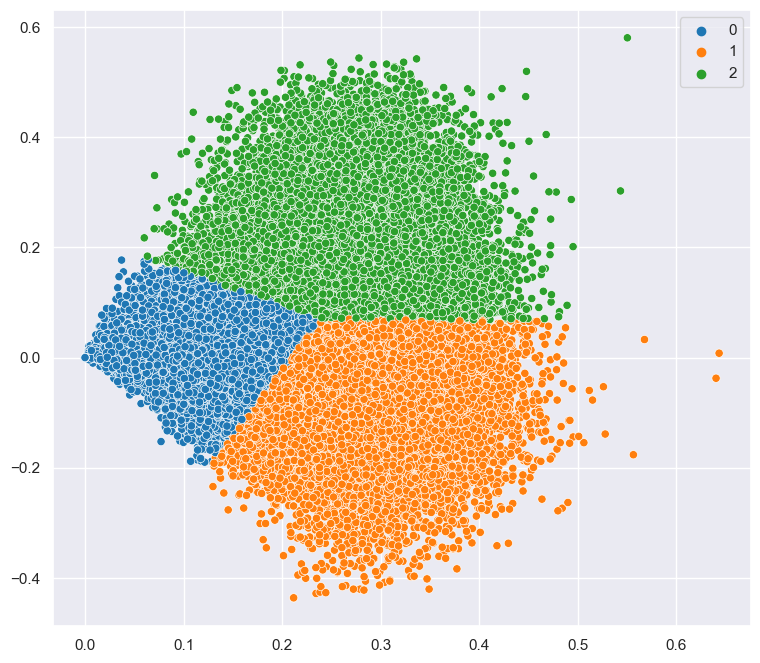

In [ ]:
plt.figure(figsize=(9, 8))
sns.scatterplot(X_pca[:,0], X_pca[:, 1], hue=clusters, palette='tab10')
plt.show()

We add the genre and the cluster label to each song

In [ ]:
X_pca_C = pd.DataFrame(X_pca).copy(deep=True)
X_pca_C['genre'] = df['genre']
X_pca_C['kmeans_labels'] = kmeans.labels_
X_pca_C

,0,1,genre,kmeans_labels
0,0.246119,0.094517,Pop,2
1,0.370430,-0.024132,Pop,1
2,0.255587,-0.090230,Pop,1
3,0.209773,0.032517,Pop,0
4,0.126211,0.023689,Pop,0
...,...,...,...,...
189383,0.203605,0.107534,Country,2
189384,0.228523,0.117143,Country,2
189385,0.282434,0.025961,Country,1
189386,0.103855,-0.050499,Country,0


In [ ]:
c_alf = ['#fa4d56', '#d12771', '#d2a106', '#33b1ff', '#d4bbff', '#6fdc8c', '#ff7eb6', '#8a3ffc', '#ba4e00', '#007d79']
col_alf = ListedColormap(sns.color_palette(c_alf).as_hex())

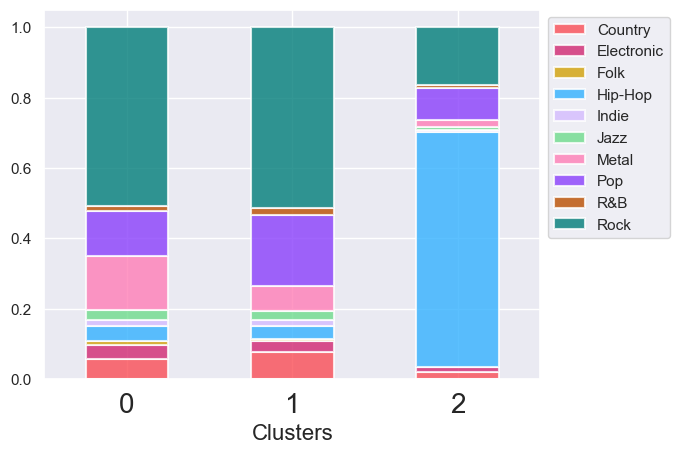

In [ ]:
bar_pl = X_pca_C['genre'].groupby(X_pca_C['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, colormap=col_alf)

plt.xticks(fontsize=20, rotation=0)
plt.xlabel('Clusters', fontsize=16)
#plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

c:\Users\crocc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


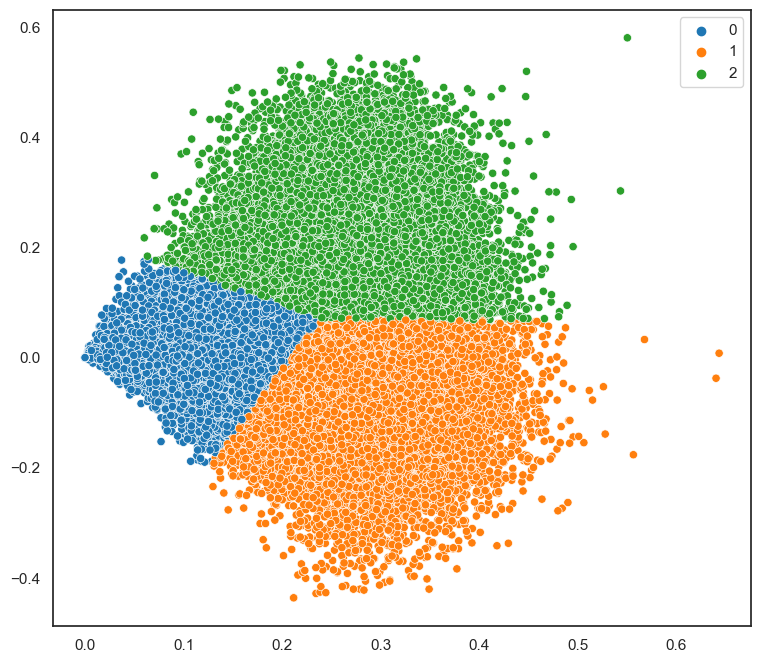

In [ ]:
sns.set_style(style='white')
plt.figure(figsize=(9, 8))
sns.scatterplot(X_pca[:,0], X_pca[:, 1], hue=clusters, palette='tab10')
plt.show()

In [ ]:
sns.set_theme()

### Bigrams

In [ ]:
### Single words and bigrams
vectorizer = TfidfVectorizer(ngram_range = (1,2), max_features=3000)
vectorizer.fit(X)
X12 = vectorizer.transform(X)

### Clustering

In [ ]:
pca = TruncatedSVD(n_components=2)
X_pca = pca.fit_transform(X12)

In [ ]:
X_pca

array([[ 0.24349978,  0.10304238],
       [ 0.33095868, -0.03427718],
       [ 0.2596247 , -0.08496855],
       ...,
       [ 0.2672324 ,  0.02234959],
       [ 0.10723186, -0.05653676],
       [ 0.06122167,  0.01652962]])

In [ ]:
sse_list = []

for k in range(2, 10):
    print(f'-- Test with k = {k}')
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    print('Fitting...')
    kmeans.fit(X_pca)
    print('Evaluating SSE...')
    sse_list.append( kmeans.inertia_ )
    #silhouette_list.append(silhouette_score(X_pca, kmeans.labels_))

-- Test with k = 2
Fitting...
Evaluating SSE...
-- Test with k = 3
Fitting...
Evaluating SSE...
-- Test with k = 4
Fitting...
Evaluating SSE...
-- Test with k = 5
Fitting...
Evaluating SSE...
-- Test with k = 6
Fitting...
Evaluating SSE...
-- Test with k = 7
Fitting...
Evaluating SSE...
-- Test with k = 8
Fitting...
Evaluating SSE...
-- Test with k = 9
Fitting...
Evaluating SSE...


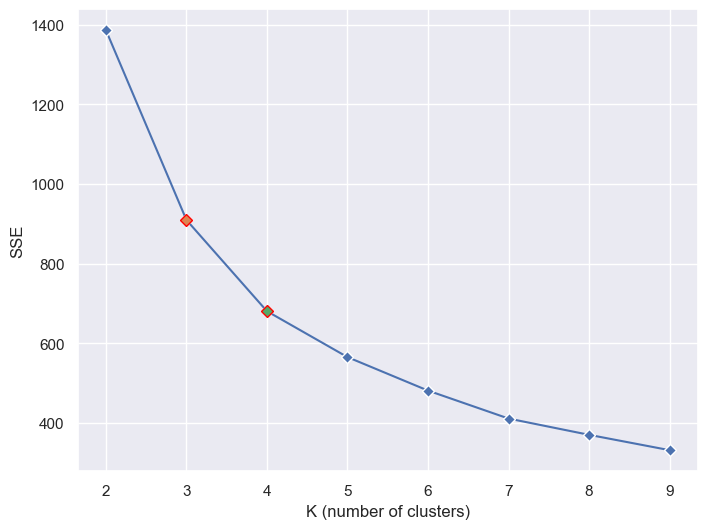

In [ ]:
# visualizzazione grafica SSE

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
plt.plot(range(2, len(sse_list)+2), sse_list, marker='D', mec='white')
plt.plot(3, sse_list[1], marker='D', mec='red')
plt.plot(4, sse_list[2], marker='D', mec='red')
plt.xlabel('K (number of clusters)')
plt.ylabel('SSE')
plt.show()

In [ ]:
silhouette_list = []

for k in range(3, 5):
    print(f'-- Test with k = {k}')
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    print('Fitting...')
    kmeans.fit(X_pca)
    print('Evaluating Silhouette Score...')
    silhouette_list.append(silhouette_score(X_pca, kmeans.labels_))

-- Test with k = 3
Fitting...
Evaluating Silhouette Score...
-- Test with k = 4
Fitting...
Evaluating Silhouette Score...


In [ ]:
silhouette_list

[0.36576620016874833, 0.3765197619486182]

In [ ]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_pca)

In [ ]:
# generazione lista centroidi

centers = kmeans.cluster_centers_
centers

array([[ 0.22316251,  0.0558568 ],
       [ 0.12354068, -0.01620685],
       [ 0.22404068, -0.06486013],
       [ 0.27192339,  0.28611238]])

c:\Users\crocc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


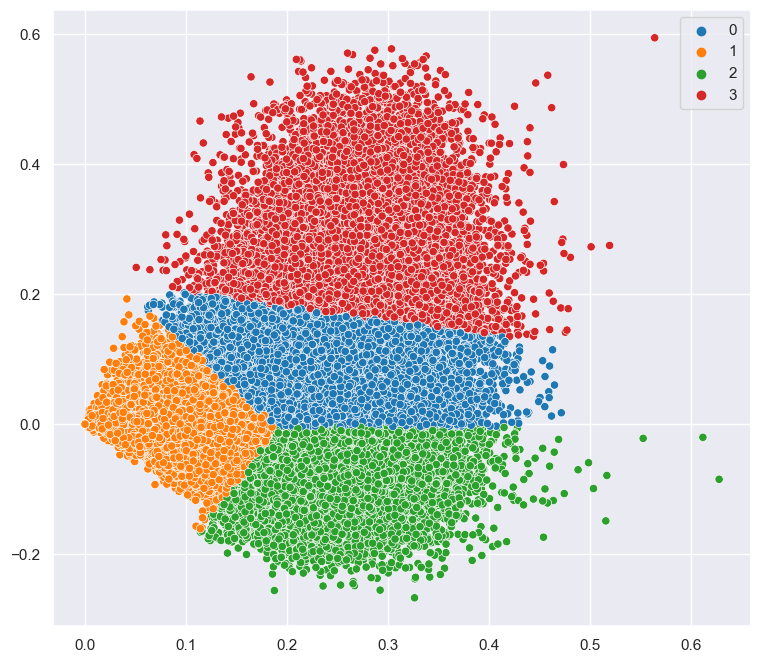

In [ ]:
plt.figure(figsize=(9, 8))
sns.scatterplot(X_pca[:,0], X_pca[:, 1], hue=clusters, palette='tab10')
plt.show()

In [ ]:
X_pca_C = pd.DataFrame(X_pca).copy(deep=True)
X_pca_C['genre'] = df['genre']
X_pca_C['kmeans_labels'] = kmeans.labels_
X_pca_C

,0,1,genre,kmeans_labels
0,0.243500,0.103042,Pop,0
1,0.330959,-0.034277,Pop,2
2,0.259625,-0.084969,Pop,2
3,0.200629,0.064534,Pop,0
4,0.170578,0.028777,Pop,0
...,...,...,...,...
189383,0.235524,0.114131,Country,0
189384,0.234134,0.113616,Country,0
189385,0.267232,0.022350,Country,0
189386,0.107232,-0.056537,Country,1


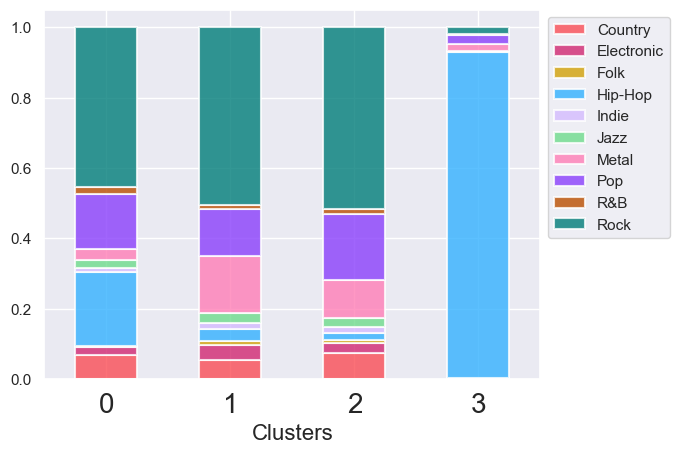

In [ ]:
bar_pl = X_pca_C['genre'].groupby(X_pca_C['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, colormap=col_alf)

plt.xticks(fontsize=20, rotation=0)
plt.xlabel('Clusters', fontsize=16)
#plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

## UMAP

In [ ]:
import umap

In [ ]:
X11_umap = umap.UMAP(n_neighbors=60, random_state=42).fit_transform(X11)

In [ ]:
sse_list = []
silhouette_list = []

for k in range(2, 10):
    print(f'-- Test with k = {k}')
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    print('Fitting...')
    kmeans.fit(X11_umap)
    print('Evaluating SSE...')
    sse_list.append( kmeans.inertia_ )
    #silhouette_list.append(silhouette_score(X_pca, kmeans.labels_))

-- Test with k = 2
Fitting...
Evaluating SSE...
-- Test with k = 3
Fitting...
Evaluating SSE...
-- Test with k = 4
Fitting...
Evaluating SSE...
-- Test with k = 5
Fitting...
Evaluating SSE...
-- Test with k = 6
Fitting...
Evaluating SSE...
-- Test with k = 7
Fitting...
Evaluating SSE...
-- Test with k = 8
Fitting...
Evaluating SSE...
-- Test with k = 9
Fitting...
Evaluating SSE...


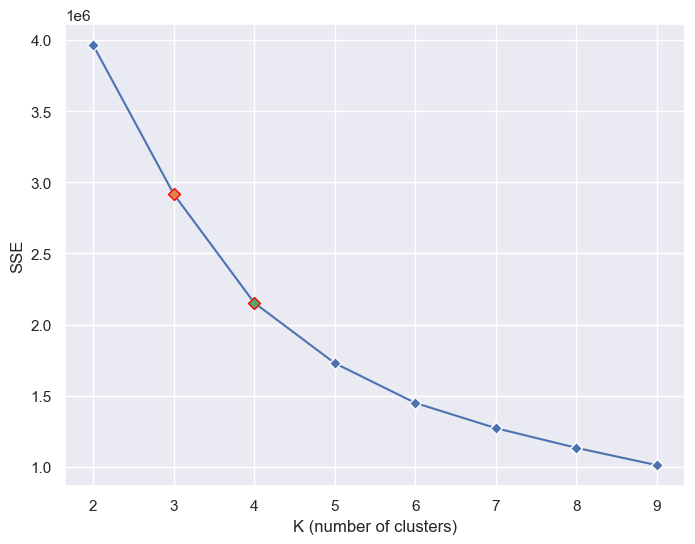

In [ ]:
# visualizzazione grafica SSE

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
plt.plot(range(2, len(sse_list)+2), sse_list, marker='D', mec='white')
plt.plot(3, sse_list[1], marker='D', mec='red')
plt.plot(4, sse_list[2], marker='D', mec='red')
plt.xlabel('K (number of clusters)')
plt.ylabel('SSE')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X11_umap)

c:\Users\crocc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


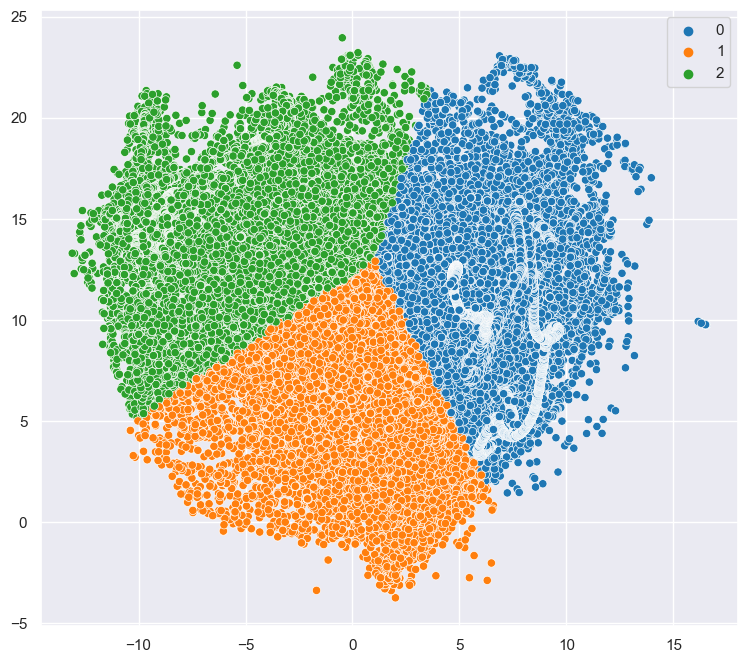

In [ ]:
plt.figure(figsize=(9, 8))
sns.scatterplot(X11_umap[:,0], X11_umap[:, 1], hue=clusters, palette='tab10')
plt.show()

In [ ]:
X_umap_C = pd.DataFrame(X11_umap).copy(deep=True)
X_umap_C['genre'] = df['genre']
X_umap_C['kmeans_labels'] = kmeans.labels_
X_umap_C

,0,1,genre,kmeans_labels
0,-4.250625,5.485641,Pop,1
1,-2.354392,7.809407,Pop,1
2,-1.060474,8.377617,Pop,1
3,-1.546254,7.424426,Pop,1
4,-2.957674,7.227717,Pop,1
...,...,...,...,...
189383,-9.359542,9.438939,Country,2
189384,4.553166,11.763018,Country,0
189385,4.694929,11.933589,Country,0
189386,4.576473,11.771181,Country,0


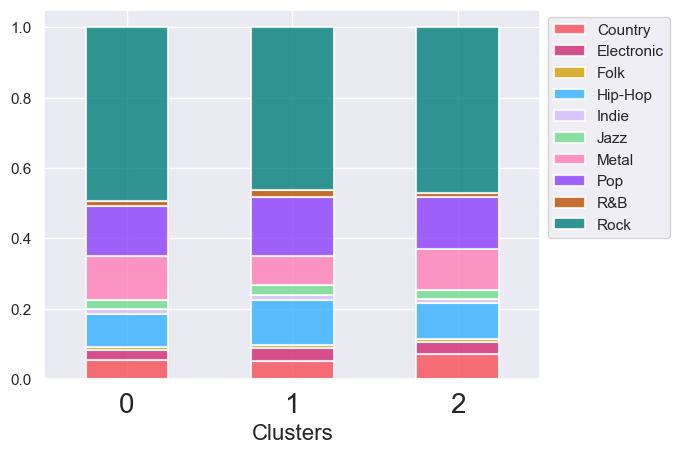

In [ ]:
bar_pl = X_umap_C['genre'].groupby(X_umap_C['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, colormap=col_alf)

plt.xticks(fontsize=20, rotation=0)
plt.xlabel('Clusters', fontsize=16)
#plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

c:\Users\crocc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


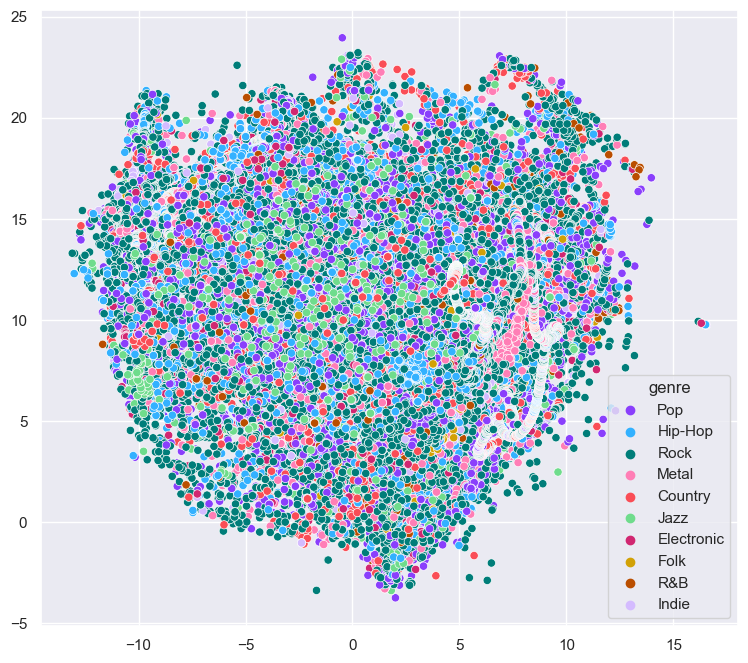

In [ ]:
plt.figure(figsize=(9, 8))
sns.scatterplot(X11_umap[:,0], X11_umap[:, 1], hue=df['genre'], palette=c)
plt.show()